# Preprocessing and Training

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
%matplotlib inline
sns.set(style="white", palette="muted", color_codes=True)

import statsmodels.api as sm
from functools import reduce

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score)
from sklearn.metrics import (auc, roc_curve, precision_recall_curve,
                             plot_precision_recall_curve, average_precision_score)
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline

import os
import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
#read the cvd_data_encoded csv file saved earlier
cvd_df = pd.read_csv('../data/cvd_data_encoded.csv')

In [3]:
cvd_df.head().T

,0,1,2,3,4
gender,1.0,0.00,0.00,0.00,1.00
age,44.0,70.00,73.00,79.00,59.00
sysbp,144.0,138.00,130.00,144.00,136.00
diabp,74.0,60.00,68.00,74.00,76.00
bmi,30.9,24.74,30.63,28.93,29.51
waistcircum,96.0,96.50,117.10,107.70,101.20
hdl,39.0,59.00,49.00,81.00,76.00
trigly,86.0,65.00,195.00,50.00,123.00
ldl,49.0,75.00,98.00,90.00,104.00
totchol,105.0,147.00,186.00,181.00,205.00


In [4]:
cvd_df.columns

Index(['gender', 'age', 'sysbp', 'diabp', 'bmi', 'waistcircum', 'hdl',
       'trigly', 'ldl', 'totchol', 'CVD_risk', 'pulse_cat', 'hypertension_cat',
       'waistcircum_cat', 'hdl_cat', 'trigly_cat', 'ldl_cat', 'totchol_cat',
       'diabetes_cat', 'kidney_cat', 'family_history_cat', 'smoking_cat',
       'gender_cat_Female', 'gender_cat_Male', 'age_cat_20s', 'age_cat_30s',
       'age_cat_40s', 'age_cat_50s', 'age_cat_60s', 'age_cat_70s & above',
       'ethnicity_cat_Black', 'ethnicity_cat_Hispanic',
       'ethnicity_cat_Mexican', 'ethnicity_cat_Other', 'ethnicity_cat_White',
       'income_cat_lower middle', 'income_cat_lowest',
       'income_cat_middle & over', 'bmi_cat_underweight', 'bmi_cat_ideal',
       'bmi_cat_overweight'],
      dtype='object')

## Dependent features

In our dataset, we kept the absolute features as well as the dummy features. It's expected to have features which are highly correlated that means which are some what linearly dependent with other features. These features contribute very less in predicting the output but increses the computational cost. So we have to find out the correlation between the features and remove the features which have correlation coefficient greater than a certain limit.

In [5]:
#set the threshold as 0.6 to drop out collinear features
threshold = 0.6

#create correlation matrix
corr_matrix = cvd_df.corr().abs()

#select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#find index of feature columns with correlation greater than 0.6
to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]

print('There are {} columns to drop with correlation > {}'.format(len(to_drop), threshold))

There are 12 columns to drop with correlation > 0.6


In [6]:
#get the names of columns to drop
to_drop

['waistcircum',
 'totchol',
 'hypertension_cat',
 'waistcircum_cat',
 'hdl_cat',
 'trigly_cat',
 'ldl_cat',
 'totchol_cat',
 'gender_cat_Female',
 'gender_cat_Male',
 'income_cat_lowest',
 'bmi_cat_overweight']

As it turns out, most of the categorical features that we created aren't contributing as much, so we will drop them.

In [7]:
#list all the column names
cvd_df.columns

Index(['gender', 'age', 'sysbp', 'diabp', 'bmi', 'waistcircum', 'hdl',
       'trigly', 'ldl', 'totchol', 'CVD_risk', 'pulse_cat', 'hypertension_cat',
       'waistcircum_cat', 'hdl_cat', 'trigly_cat', 'ldl_cat', 'totchol_cat',
       'diabetes_cat', 'kidney_cat', 'family_history_cat', 'smoking_cat',
       'gender_cat_Female', 'gender_cat_Male', 'age_cat_20s', 'age_cat_30s',
       'age_cat_40s', 'age_cat_50s', 'age_cat_60s', 'age_cat_70s & above',
       'ethnicity_cat_Black', 'ethnicity_cat_Hispanic',
       'ethnicity_cat_Mexican', 'ethnicity_cat_Other', 'ethnicity_cat_White',
       'income_cat_lower middle', 'income_cat_lowest',
       'income_cat_middle & over', 'bmi_cat_underweight', 'bmi_cat_ideal',
       'bmi_cat_overweight'],
      dtype='object')

In [8]:
#create objects X and y to store the data (after dropping correlated features) and the target value respectively.
X = cvd_df.drop(['CVD_risk', 'waistcircum', 'totchol','hypertension_cat',
                 'hdl_cat', 'trigly_cat', 'ldl_cat', 'totchol_cat',
                 'gender_cat_Female', 'gender_cat_Male', 'bmi_cat_underweight',
                 'bmi_cat_ideal', 'bmi_cat_overweight', 'age_cat_20s',
                 'age_cat_30s','age_cat_40s', 'age_cat_50s', 'age_cat_60s',
                 'age_cat_70s & above'] , axis=1)
y = cvd_df['CVD_risk']

In [9]:
#print the first five rows
X.columns

Index(['gender', 'age', 'sysbp', 'diabp', 'bmi', 'hdl', 'trigly', 'ldl',
       'pulse_cat', 'waistcircum_cat', 'diabetes_cat', 'kidney_cat',
       'family_history_cat', 'smoking_cat', 'ethnicity_cat_Black',
       'ethnicity_cat_Hispanic', 'ethnicity_cat_Mexican',
       'ethnicity_cat_Other', 'ethnicity_cat_White', 'income_cat_lower middle',
       'income_cat_lowest', 'income_cat_middle & over'],
      dtype='object')

In [10]:
X.head()

,gender,age,sysbp,diabp,bmi,hdl,trigly,ldl,pulse_cat,waistcircum_cat,...,family_history_cat,smoking_cat,ethnicity_cat_Black,ethnicity_cat_Hispanic,ethnicity_cat_Mexican,ethnicity_cat_Other,ethnicity_cat_White,income_cat_lower middle,income_cat_lowest,income_cat_middle & over
0,1,44,144,74,30.90,39,86,49,0,0,...,1,0,1,0,0,0,0,0,0,1
1,0,70,138,60,24.74,59,65,75,0,1,...,0,0,0,0,0,0,1,0,0,1
2,0,73,130,68,30.63,49,195,98,0,1,...,0,0,0,0,0,0,1,1,0,0
3,0,79,144,74,28.93,81,50,90,0,1,...,0,1,0,0,0,0,1,0,1,0
4,1,59,136,76,29.51,76,123,104,0,0,...,1,1,1,0,0,0,0,1,0,0


## Split the data into train, validation and test sets

In [11]:
#split the dataset into train(60%), test(20%) and validation sets(20%)
X_tr, X_te, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
X_tr, X_va, y_train, y_val = train_test_split(X_tr, y_train, test_size=0.25, random_state=123)

In [12]:
#confirming the ratios of train, test and validation sets for X
print('Percent heldout for training:', round(100*(len(X_tr)/len(cvd_df)),0),'%')
print('Percent heldout for validation', round(100*(len(X_va)/len(cvd_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(X_te)/len(cvd_df)),0),'%')

Percent heldout for training: 60.0 %
Percent heldout for validation 20.0 %
Percent heldout for testing: 20.0 %


In [13]:
#confirming the ratios of train, test and validation sets for y
print('Percent heldout for training:', round(100*(len(y_train)/len(cvd_df)),0),'%')
print('Percent heldout for validation', round(100*(len(y_val)/len(cvd_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(y_test)/len(cvd_df)),0),'%')

Percent heldout for training: 60.0 %
Percent heldout for validation 20.0 %
Percent heldout for testing: 20.0 %


## Data Normalization

In [14]:
#since each feature is on a different scale, normalization is required. split the data based on the columns
#that need scaling
to_scale = ['age', 'sysbp', 'diabp', 'bmi', 'hdl', 'trigly','ldl']
not_to_scale = ['gender', 'pulse_cat', 'waistcircum_cat', 'diabetes_cat', 'kidney_cat',
                'family_history_cat', 'smoking_cat', 'ethnicity_cat_Black',
                'ethnicity_cat_Hispanic', 'ethnicity_cat_Mexican',
                'ethnicity_cat_Other', 'ethnicity_cat_White','income_cat_lower middle',
                'income_cat_lowest', 'income_cat_middle & over']

In [15]:
#normalize the features for X_tr and call the scaled dataset X_train so that each column/feature/variable will
#have μ = 0 and σ = 1
scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(X_tr[to_scale]),columns=X_tr[to_scale].columns).reset_index(drop=True)
X_train=pd.concat([scaled_train, X_tr[not_to_scale].reset_index(drop=True)], axis=1)

In [16]:
#normalize the features for X_va and call the scaled dataset X_val so that each column/feature/variable will
#have μ = 0 and σ = 1
scaled_val = pd.DataFrame(scaler.transform(X_va[to_scale]),columns=X_va[to_scale].columns).reset_index(drop=True)
X_val=pd.concat([scaled_val, X_va[not_to_scale].reset_index(drop=True)], axis=1)

In [17]:
#normalize the features for X_te and call the scaled dataset X_test so that each column/feature/variable will
#have μ = 0 and σ = 1
scaled_test = pd.DataFrame(scaler.transform(X_te[to_scale]),columns=X_te[to_scale].columns).reset_index(drop=True)
X_test=pd.concat([scaled_test, X_te[not_to_scale].reset_index(drop=True)], axis=1)

In [18]:
#print the first five rows for X_train
X_train.head().T

,0,1,2,3,4
age,-1.491921,1.516454,-1.547632,-0.934815,-1.659053
sysbp,-0.751932,-0.306587,-0.529260,-0.417924,-1.531285
diabp,-0.750008,-0.100995,-0.425502,1.197030,-1.074514
bmi,1.086766,0.830579,-0.298973,0.051829,-1.520228
hdl,-0.842354,1.022038,-0.283037,-0.780208,0.897745
trigly,-0.232706,-0.395660,2.078267,1.293129,-0.899333
ldl,0.936988,1.441285,-0.744002,1.665417,-0.912101
gender,0.000000,1.000000,1.000000,0.000000,1.000000
pulse_cat,0.000000,0.000000,0.000000,0.000000,0.000000
waistcircum_cat,1.000000,1.000000,0.000000,1.000000,0.000000


In [19]:
#print the first five rows for X_val
X_val.head().T

,0,1,2,3,4
age,1.460743,-0.266287,0.179398,-0.767683,-1.269079
sysbp,-0.195251,0.138757,-0.751932,-1.753957,0.250093
diabp,0.061258,1.034777,0.710270,-1.723527,-0.425502
bmi,1.027086,0.022716,2.495794,-0.792424,-0.521681
hdl,-0.780208,-1.153086,-0.655915,0.959891,-0.904501
trigly,1.115361,0.374665,-0.766008,-1.165984,1.144989
ldl,-0.267722,2.113681,-0.015573,-1.192266,1.077071
gender,1.000000,0.000000,1.000000,1.000000,0.000000
pulse_cat,0.000000,0.000000,0.000000,0.000000,0.000000
waistcircum_cat,1.000000,1.000000,1.000000,0.000000,1.000000


In [20]:
#print the first five rows for X_test
X_test.head().T

,0,1,2,3,4
age,1.516454,-1.213368,-0.823393,0.847926,-1.603342
sysbp,2.588152,-0.640596,-0.306587,1.474791,-0.195251
diabp,0.385764,0.710270,-0.263248,0.548017,-1.885780
bmi,-1.288786,-1.568263,0.997974,-1.365934,-0.486746
hdl,-0.283037,2.389259,-0.158744,-0.966647,-0.718062
trigly,0.641316,-0.958589,-0.766008,1.159803,3.026359
ldl,0.516741,-0.659953,0.012444,0.488724,-0.687969
gender,1.000000,1.000000,1.000000,0.000000,0.000000
pulse_cat,0.000000,0.000000,0.000000,0.000000,0.000000
waistcircum_cat,0.000000,0.000000,0.000000,1.000000,1.000000


## Naive baseline

Now that the dataset is split into training, testing and validation sets, let's try a naive baseline for comparison

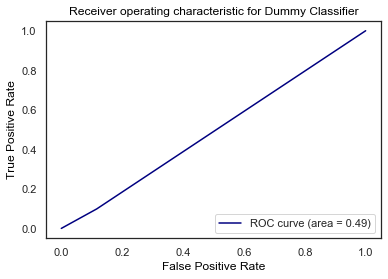

In [21]:
from sklearn.dummy import DummyClassifier
dummy_cl = DummyClassifier()
dummy_cl.fit(X_train, y_train)
y_pred_prob = dummy_cl.predict(X_val)
y_pred = dummy_cl.predict(X_val)

fp_tp_dummy = roc_curve(y_val, y_pred)
plt.plot(fp_tp_dummy[0], fp_tp_dummy[1], color='navy',label='ROC curve (area = %0.2f)' %(auc(fp_tp_dummy[0], fp_tp_dummy[1])))
plt.xlabel('False Positive Rate', color='black', fontsize=12)
plt.ylabel('True Positive Rate', color='black', fontsize=12)
plt.title('Receiver operating characteristic for Dummy Classifier', color='black', fontsize=12)
plt.legend(loc="lower right")
plt.show()

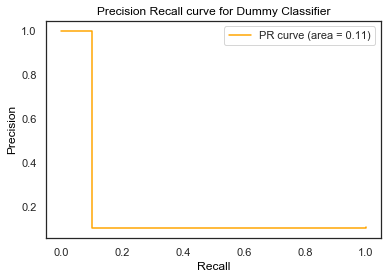

Precision: 0.0934
Recall: 0.0987


In [22]:
pr_dummy = precision_recall_curve(y_val, y_pred_prob)
plt.step(pr_dummy[1], pr_dummy[0], color='orange',
         label='PR curve (area = %0.2f)' %(average_precision_score(y_val, y_pred_prob)))
plt.xlabel('Recall', color='black', fontsize=12)
plt.ylabel('Precision', color='black', fontsize=12)
plt.title('Precision Recall curve for Dummy Classifier', color='black', fontsize=12)
plt.legend(loc="upper right")
plt.show()

print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))

In [23]:
precision_score(y_val, y_pred)

0.09337349397590361

We can see that these metrics are very poor! With no machine learning, we are only able to identify 10% of the indivisuals with CVD risk and only 10% of those predicted are actually true. A naive approach clearly does not provide much value.

In [24]:
print('The percentage of patients with CVD risk in training data:', round(100 * round(np.mean(y), 4)),'%')

The percentage of patients with CVD risk in training data: 11 %


## Machine learning

### Base Model Evaluation

Now we need to see if machine learning is up to the task of improving on these predictions. We'll start simple, using a classification models to assess without hyperparaneter tuning on bith training and validation sets to understand tehir performance.

For an imbalanced classification problem, there are a number of metrics to consider:

- Receiver Operating Characteristic Area Under the Curve (ROC AUC): a measure between 0 and 1 comparing the performance of the classifier when predicting probabilities across a range of thresholds.
- Precision Score: number of true positives divided by the total number of positives predicted
- Recall Score: number of true positives divided by the total number of actual positives in the data
- F1 Score: Harmonic mean of precision and recall
- Precision Recall Area Under the Curve (PR AUC): shows the tradeoff between precision and recall for different thresholds.

In [25]:
def model_fit(alg, X_train, X_val, y_train, y_val, title, plot=True):
    
    #fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train)
    y_train_predprob = alg.predict_proba(X_train)[:,1]
    
    y_val_pred = alg.predict(X_val)
    y_val_predprob = alg.predict_proba(X_val)[:,1]
    
    #get precision, recall and threshold on train and validation sets:
    prf_train=precision_recall_fscore_support(y_train, y_train_pred, pos_label=1, average='binary')
    prf_val=precision_recall_fscore_support(y_val, y_val_pred, pos_label=1, average='binary')
    
    #get average precision on train and validation sets:
    area_prc_train=average_precision_score(y_train, y_train_predprob, average=None)
    area_prc_val=average_precision_score(y_val, y_val_predprob, average=None)
    
    precision_train, recall_train, thr_train = precision_recall_curve(y_train, y_train_predprob, pos_label=1)
    precision_val, recall_val, thr_val = precision_recall_curve(y_val, y_val_predprob, pos_label=1)
    
    #get get positives and true positives on train and validation sets:
    fp_tp_train = roc_curve(y_train, y_train_pred)
    fp_tp_val = roc_curve(y_val, y_val_pred) 
    
    print ("Model report on training data:")
    print ("Train: Precision: %.4f" %(prf_train[0]))
    print ("Train: Recall : %.4f" %(prf_train[1]))
    print ("Average Precision (Train): %.4f" %(area_prc_train))
    print ("ROC AUC (Train): %.4f" %(auc(fp_tp_train[0], fp_tp_train[1])))
    print('Train Accuracy: %.4f' %(accuracy_score(alg.predict(X_train),y_train)))
    print ("\nModel report on validation data:")
    print ("Validation: Precision: %.4f" %(prf_val[0]))
    print ("Validation: Recall : %.4f" %(prf_val[1]))
    print ("Average Precision (Validation): %.4f" % (area_prc_val))
    print ("ROC AUC (Validation): %.4f" %(auc(fp_tp_val[0], fp_tp_val[1])))
    print('Validation Accuracy: %0.4f' %(accuracy_score(alg.predict(X_val),y_val)))
    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(recall_val, precision_val, color='navy',label=' Validation PR-Curve')
        plt.plot(recall_train, precision_train, color='orange',label=' Train PR-Curve')
        plt.xlabel('Recall', color='black', fontsize=14)
        plt.ylabel('Precision', color='black', fontsize=14)
        plt.title(title, fontsize=16)
        plt.legend(loc="lower left")
        plt.show()

In [26]:
def plot_results(targets,predictions,title):
    
    #plot barplots of precision and recall for both classes for training and test sets:
    tn, fp, fn, tp = confusion_matrix(targets,predictions).ravel()

    n_precision = tn/(tn+fn)
    n_recall = tn/(tn+fp)
        
    p_precision = tp/(tp+fp)
    p_recall = tp/(tp+fn)

    precision = [n_precision, p_precision]
    recall = [n_recall, p_recall]
      
    k = 0.1
    ax.bar([2+k,5+k],precision,color='#0085f9')
    ax.bar([3-k,6-k],recall,color='#00176d')
    ax.set_xticks([2.5,5.5])
    ax.set_xticklabels(['No_CVD_Risk', 'CVD_Risk'],fontsize=14)
    ax.set_xlim([1,7])
    ax.set_ylim([0,1.3])
    ax.legend(['Precision','Recall'],fontsize=12)
    ax.set_title(title,fontsize=16)
    plt.tight_layout()

#### Logistic Regression

Let's use logistic regression in order to see baseline performance on this problem.

Model report on training data:
Train: Precision: 0.5442
Train: Recall : 0.1641
Average Precision (Train): 0.4211
ROC AUC (Train): 0.5734
Train Accuracy: 0.8908

Model report on validation data:
Validation: Precision: 0.5393
Validation: Recall : 0.1529
Average Precision (Validation): 0.4116
ROC AUC (Validation): 0.5685
Validation Accuracy: 0.8941


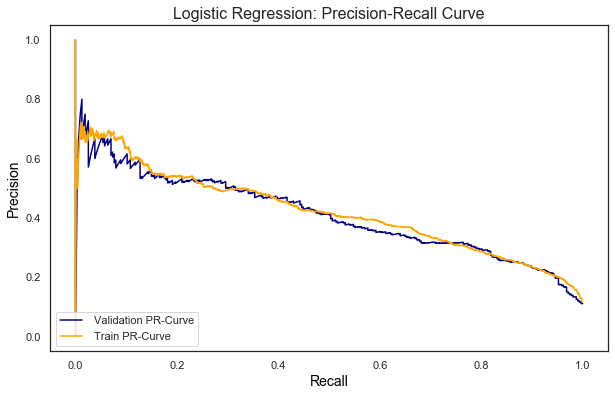

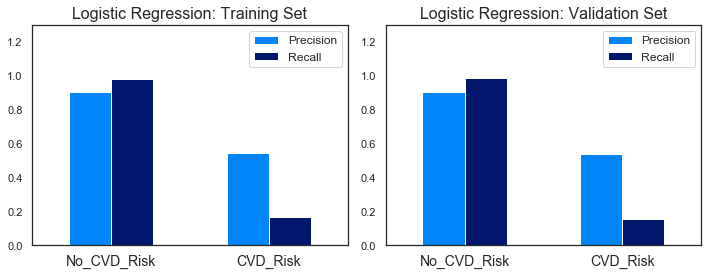

In [27]:
#fit logistic regression and predict y
lr = LogisticRegression(random_state=42)
model_fit(lr, X_train, X_val, y_train, y_val, 'Logistic Regression: Precision-Recall Curve')

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
plot_results(y_train,lr.predict(X_train),'Logistic Regression: Training Set')
ax = fig.add_subplot(1,2,2)
plot_results(y_val,lr.predict(X_val),'Logistic Regression: Validation Set')

Recall on the positive CVD cases is fairly low (about 15%) for both the training and test sets, however, the precision  is  good (about 55%) for both the training and test sets. The model seems to be good at correctly predicting cases with no CVD risk but is excessively likely to predict cases as negative.
One postive thing about this model is that the training dataset results closely match the validation set results, implying that model is neither underfitting nor overfitting.

### Support Vector Classifier

Now, let's evaluate the performance of Support Vector Classifier.

Model report on training data:
Train: Precision: 0.8814
Train: Recall : 0.1067
Average Precision (Train): 0.6490
ROC AUC (Train): 0.5524
Train Accuracy: 0.8982

Model report on validation data:
Validation: Precision: 0.5227
Validation: Recall : 0.0732
Average Precision (Validation): 0.3765
ROC AUC (Validation): 0.5326
Validation Accuracy: 0.8923


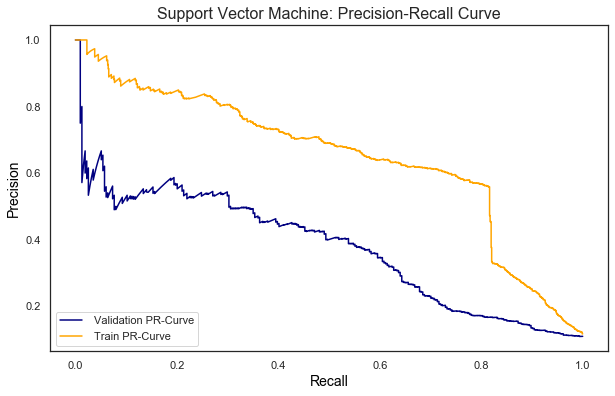

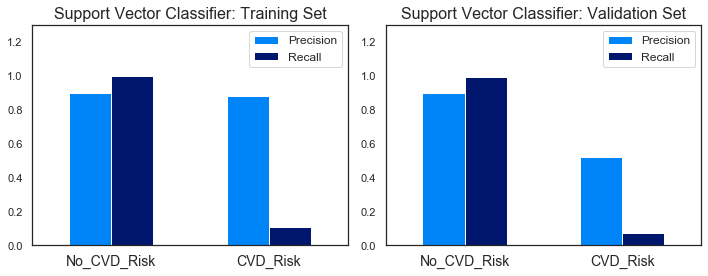

In [28]:
#fit support vector classifier and predict y
svc = SVC(random_state=42, probability=True)  
model_fit(svc,X_train, X_val, y_train, y_val, 'Support Vector Machine: Precision-Recall Curve', True)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
plot_results(y_train,svc.predict(X_train),'Support Vector Classifier: Training Set')
ax = fig.add_subplot(1,2,2)
plot_results(y_val,svc.predict(X_val),'Support Vector Classifier: Validation Set')

Support Vector Classifier is overfitting the training data as can be observed by the higher precision for training dataset. It is also showing a much lower recall on CVD risk cases.

### Random Forest Classifier

Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.5526
Validation: Recall : 0.1338
Average Precision (Validation): 0.4094
ROC AUC (Validation): 0.5603
Validation Accuracy: 0.8944


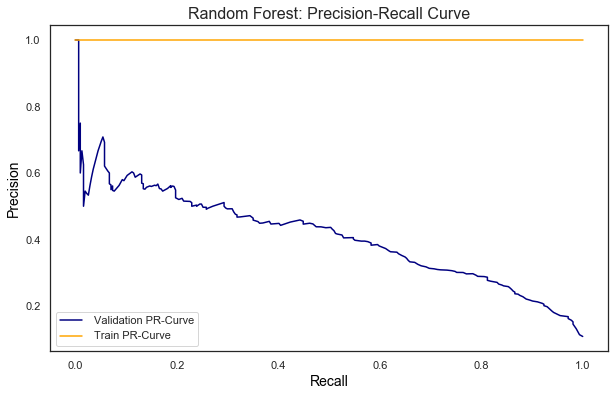

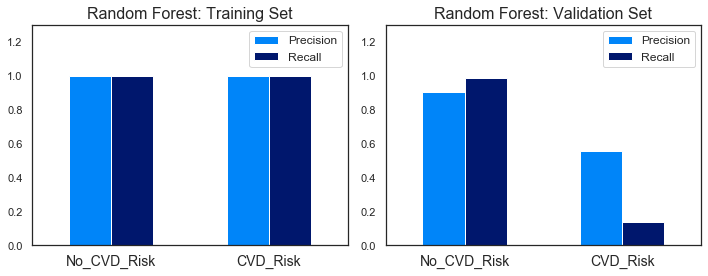

In [29]:
#fit random forest classifier and predict y
rf = RandomForestClassifier(random_state=42, n_estimators = 300)
model_fit(rf,X_train, X_val, y_train, y_val, 'Random Forest: Precision-Recall Curve', True)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
plot_results(y_train,rf.predict(X_train),'Random Forest: Training Set')
ax = fig.add_subplot(1,2,2)
plot_results(y_val,rf.predict(X_val),'Random Forest: Validation Set')

Random Forest is grossly overfitting the training dataset and is showing 100% recall and precision. The performance on the validation set is similar to that of Logistic Regression.

Model report on training data:
Train: Precision: 0.7237
Train: Recall : 0.2821
Average Precision (Train): 0.5424
ROC AUC (Train): 0.6342
Train Accuracy: 0.9074

Model report on validation data:
Validation: Precision: 0.4196
Validation: Recall : 0.1497
Average Precision (Validation): 0.2703
ROC AUC (Validation): 0.5623
Validation Accuracy: 0.8854


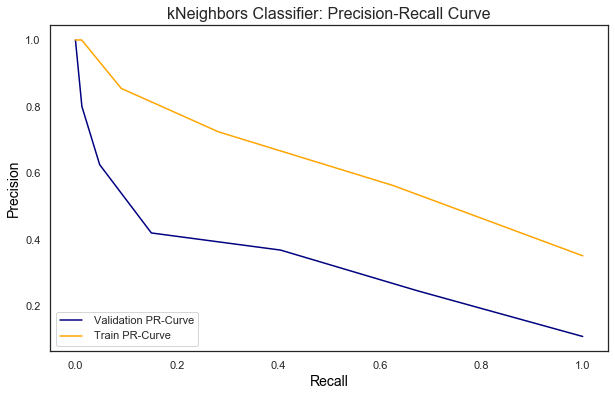

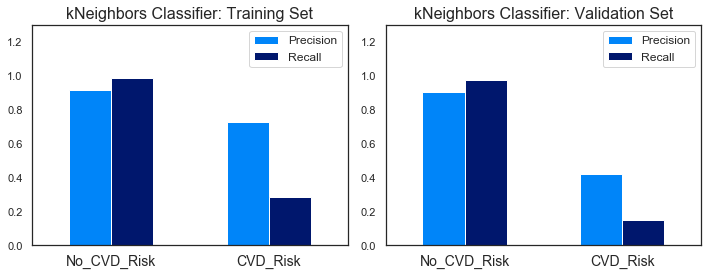

In [30]:
#fit kneighbors classifier and predict y
knn = KNeighborsClassifier()
model_fit(knn, X_train, X_val, y_train, y_val, 'kNeighbors Classifier: Precision-Recall Curve', True)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
plot_results(y_train,knn.predict(X_train),'kNeighbors Classifier: Training Set')
ax = fig.add_subplot(1,2,2)
plot_results(y_val,knn.predict(X_val),'kNeighbors Classifier: Validation Set')

Again, the model seems to be overfitting the training dataset but shows a better recall on the test set compared to the other models.

Next, we will compare the metrics (accuracy, precision, recall, f1, ROC AUC, PRC AUC) for all the models and plot their precision recall curves.

In [31]:
#define a function to plot confusion matrix
def confusion_matrix_plot(model):
    y_pred = model.predict(X_val)
    model_matrix = confusion_matrix(y_val,y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=model_matrix)
    plt.show()

In [32]:
#define a function to show and plot the metrics for different models
def show_metrics(X_tr, y_tr, title):
    MLA = [lr, knn, rf, svc]
    MLA_columns = []
    MLA_compare = pd.DataFrame(columns = MLA_columns)
    row_index = 0
    plt.figure(figsize=(10,6))
    for alg in MLA:
        pred = alg.fit(X_tr, y_tr).predict(X_val)
        pred_prob = alg.predict_proba(X_val)
        fp, tp, th = roc_curve(y_val, pred)     
        y_score = pred_prob[:,1]
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index,'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'Accuracy'] = accuracy_score(y_val, pred)
        MLA_compare.loc[row_index, 'Precision'] = precision_score(y_val, pred)
        MLA_compare.loc[row_index, 'Recall'] = recall_score(y_val, pred)
        MLA_compare.loc[row_index, 'F-1 score'] = f1_score(y_val, pred)
        MLA_compare.loc[row_index, 'ROC_AUC'] = auc(fp, tp)
        
        alg_precision, alg_recall, alg_thresholds = precision_recall_curve(y_val, y_score)
        MLA_compare.loc[row_index, 'PRC_AUC'] = auc(alg_recall, alg_precision)
        
        plt.step(alg_recall, alg_precision, marker='.', markersize=1, label=MLA_name)
        plt.xlabel('Recall', color='black', fontsize=14)
        plt.ylabel('Precision', color='black', fontsize=14)
        plt.title(title, fontsize=16, color='black')
        plt.legend(fontsize=12)
        
        row_index+=1
        
    return(MLA_compare)    

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.894065,0.539326,0.152866,0.238213,0.568500,0.408745
1,KNeighborsClassifier,0.885438,0.419643,0.149682,0.220657,0.562263,0.330494
2,RandomForestClassifier,0.894410,0.552632,0.133758,0.215385,0.560300,0.408971
3,SVC,0.892340,0.522727,0.073248,0.128492,0.532561,0.374835


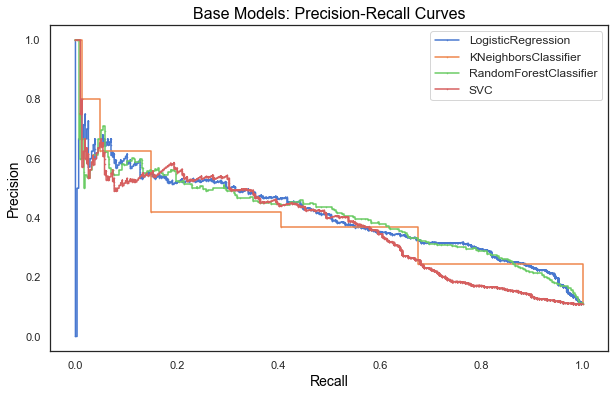

In [33]:
show_metrics(X_train, y_train, 'Base Models: Precision-Recall Curves')

## Resampling Strategies

Since our positive CVD risk cases comprise 11% of the total cases,we will use some techniques to handle this highly unbalanced dataset, with a focus on following resampling methods:
- Random oversampling: randomly duplicate examples in the majority class
- Random undersampling: randomly delete examples in the minority class
- Synthetic Minority Oversampling Technique(SMOTE): selects examples that are close in the feature space, draws a line between the examples and draws a new sample at a point along that line
- SMOTEENN: combines over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [33]:
ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()
smoteenn = SMOTEENN()
columns = X_train.columns

In [34]:
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('KNeighbors Classifier', KNeighborsClassifier()))
models.append(('RandomForest Classifier', RandomForestClassifier()))
models.append(('Support Vector Classifier', SVC(probability=True)))

In [81]:
def resamp_eval(resamp_alg, X_tr, y_tr):
    names = []
    for name, model in models:
        names.append(name)
        print(name)
        model_fit(model, X_tr, X_val, y_tr, y_val, 'Resampled Precision Recall curves', True)

Now we will perform the comparison of models using various sampling techniques.

### Oversampling

In [35]:
#use oversampling to fit the models and predict y
os_X, os_y = ros.fit_sample(X_train, y_train)
os_X = pd.DataFrame(data=os_X, columns=columns )
os_y = pd.DataFrame(data=os_y, columns=['CVD_risk'])

Logistic Regression
Model report on training data:
Train: Precision: 0.5442
Train: Recall : 0.1641
Average Precision (Train): 0.4211
ROC AUC (Train): 0.5734
Train Accuracy: 0.8908

Model report on validation data:
Validation: Precision: 0.5393
Validation: Recall : 0.1529
Average Precision (Validation): 0.4116
ROC AUC (Validation): 0.5685
Validation Accuracy: 0.8941


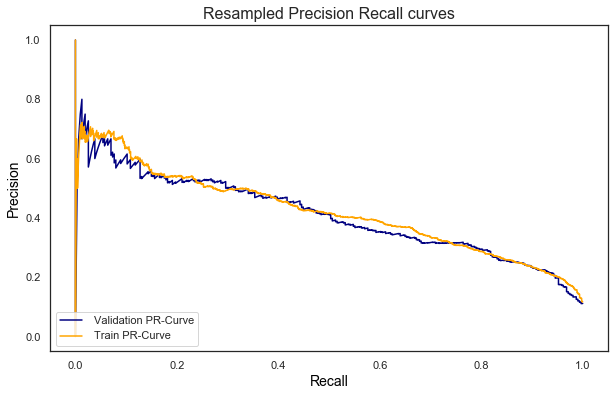

KNeighbors Classifier
Model report on training data:
Train: Precision: 0.7237
Train: Recall : 0.2821
Average Precision (Train): 0.5424
ROC AUC (Train): 0.6342
Train Accuracy: 0.9074

Model report on validation data:
Validation: Precision: 0.4196
Validation: Recall : 0.1497
Average Precision (Validation): 0.2703
ROC AUC (Validation): 0.5623
Validation Accuracy: 0.8854


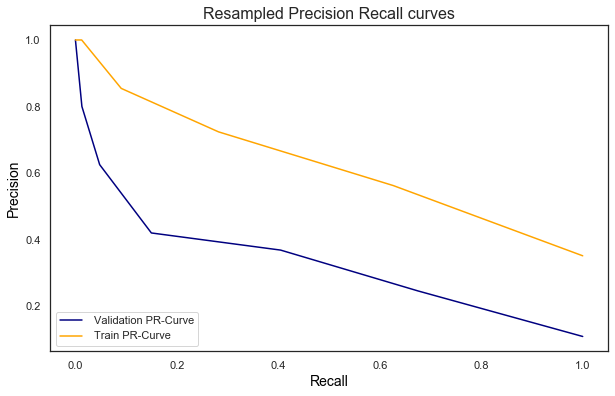

RandomForest Classifier
Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.5309
Validation: Recall : 0.1369
Average Precision (Validation): 0.4001
ROC AUC (Validation): 0.5611
Validation Accuracy: 0.8934


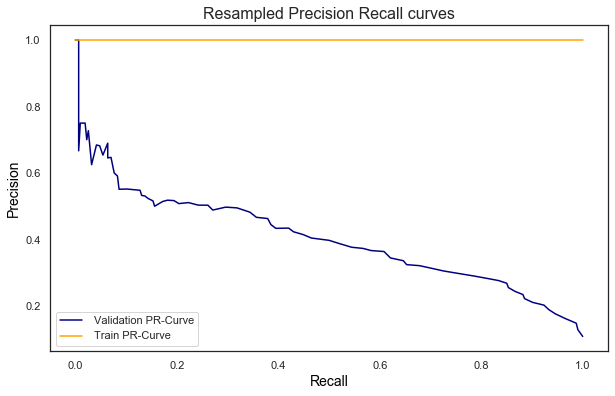

Support Vector Classifier
Model report on training data:
Train: Precision: 0.8814
Train: Recall : 0.1067
Average Precision (Train): 0.6490
ROC AUC (Train): 0.5524
Train Accuracy: 0.8982

Model report on validation data:
Validation: Precision: 0.5227
Validation: Recall : 0.0732
Average Precision (Validation): 0.3765
ROC AUC (Validation): 0.5326
Validation Accuracy: 0.8923


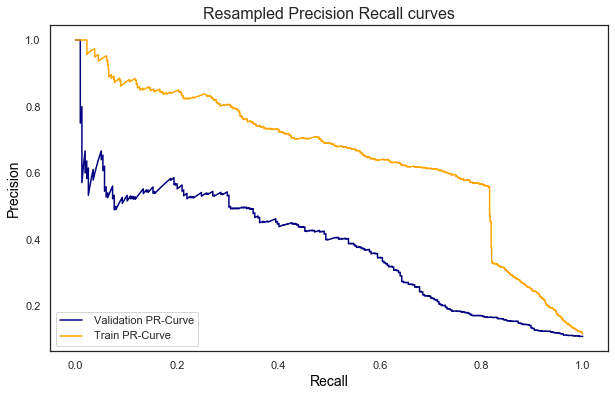

In [83]:
resamp_eval(ros, X_train, y_train)

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.758454,0.282658,0.799363,0.417637,0.776423,0.398602
1,KNeighborsClassifier,0.796411,0.276699,0.544586,0.366953,0.685799,0.354080
2,RandomForestClassifier,0.892340,0.506250,0.257962,0.341772,0.613695,0.406513
3,SVC,0.770186,0.280000,0.713376,0.402154,0.745233,0.349132


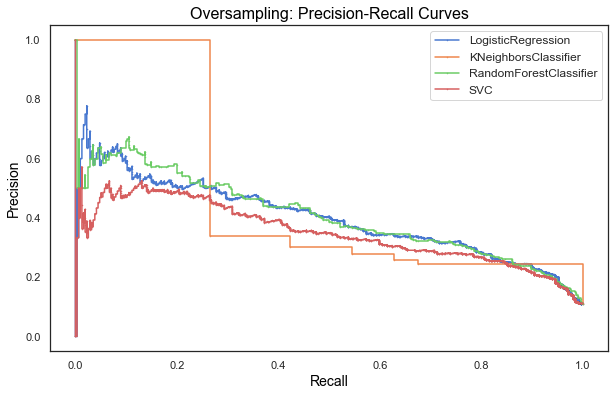

In [39]:
show_metrics(os_X, os_y, 'Oversampling: Precision-Recall Curves')

Oversampling has resulted in a huge improvement in recall but a reduction in precision also known as precision/recall tradeoff. The logistic regression model in particular stands out sue to its high recall.

### Undersampling

In [36]:
#use undersampling to fit the models and predict y
us_X, us_y = rus.fit_sample(X_train, y_train)
us_X = pd.DataFrame(data=us_X, columns=columns )
us_y = pd.DataFrame(data=us_y, columns=['CVD_risk'])

Logistic Regression
Model report on training data:
Train: Precision: 0.5442
Train: Recall : 0.1641
Average Precision (Train): 0.4211
ROC AUC (Train): 0.5734
Train Accuracy: 0.8908

Model report on validation data:
Validation: Precision: 0.5393
Validation: Recall : 0.1529
Average Precision (Validation): 0.4116
ROC AUC (Validation): 0.5685
Validation Accuracy: 0.8941


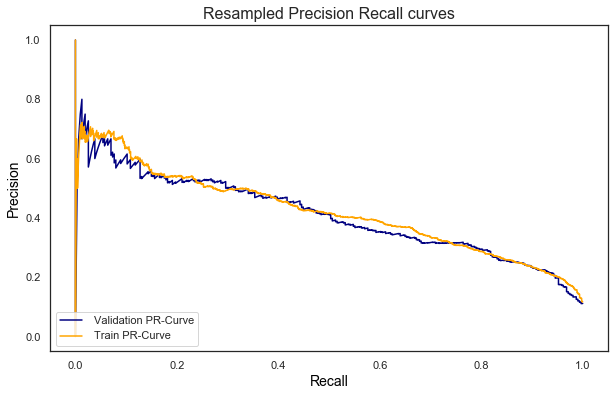

KNeighbors Classifier
Model report on training data:
Train: Precision: 0.7237
Train: Recall : 0.2821
Average Precision (Train): 0.5424
ROC AUC (Train): 0.6342
Train Accuracy: 0.9074

Model report on validation data:
Validation: Precision: 0.4196
Validation: Recall : 0.1497
Average Precision (Validation): 0.2703
ROC AUC (Validation): 0.5623
Validation Accuracy: 0.8854


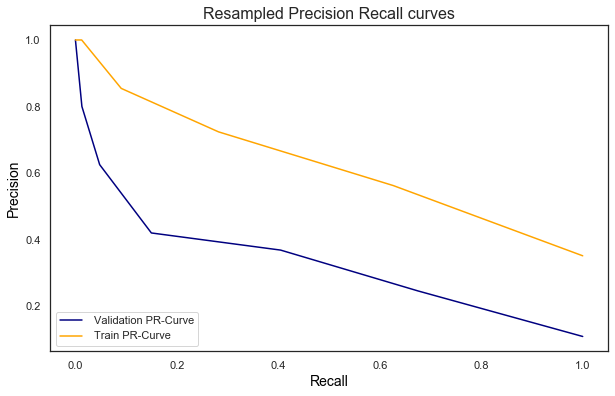

RandomForest Classifier
Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.5333
Validation: Recall : 0.1274
Average Precision (Validation): 0.4084
ROC AUC (Validation): 0.5569
Validation Accuracy: 0.8934


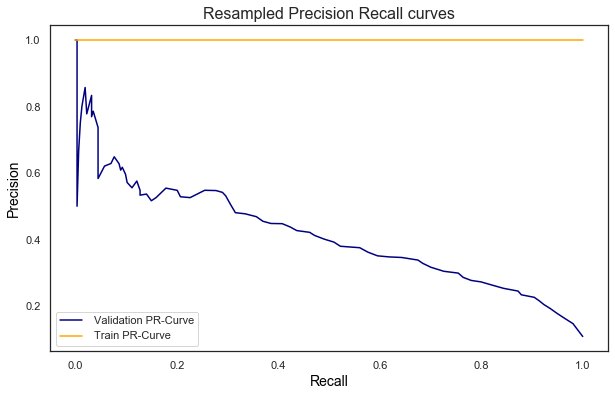

Support Vector Classifier
Model report on training data:
Train: Precision: 0.8814
Train: Recall : 0.1067
Average Precision (Train): 0.6490
ROC AUC (Train): 0.5524
Train Accuracy: 0.8982

Model report on validation data:
Validation: Precision: 0.5227
Validation: Recall : 0.0732
Average Precision (Validation): 0.3766
ROC AUC (Validation): 0.5326
Validation Accuracy: 0.8923


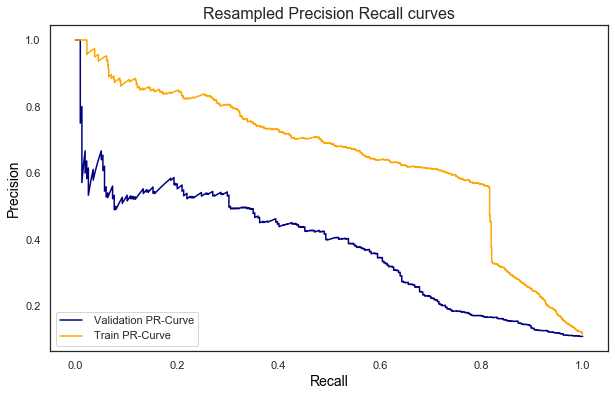

In [84]:
resamp_eval(rus, X_train, y_train)

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.753623,0.279736,0.808917,0.415712,0.777911,0.377666
1,KNeighborsClassifier,0.736025,0.251925,0.729299,0.374489,0.733071,0.340833
2,RandomForestClassifier,0.733954,0.263212,0.808917,0.397185,0.766881,0.369949
3,SVC,0.719462,0.256585,0.837580,0.392830,0.771344,0.336246


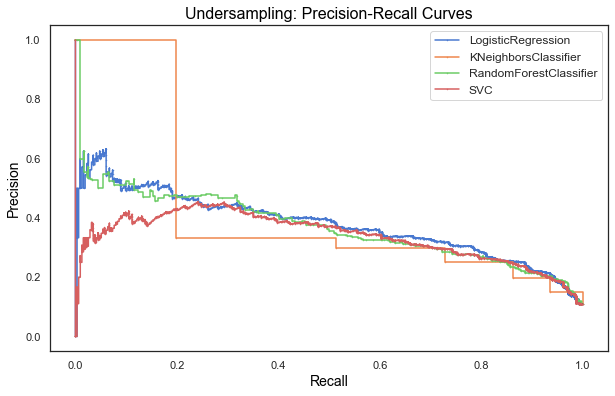

In [42]:
show_metrics(us_X, us_y, 'Undersampling: Precision-Recall Curves')

Undersampling shows a similar improvement in recall as well.

### SMOTE

In [37]:
#use SMOTE to fit the models and predict y
smote_X, smote_y = smote.fit_sample(X_train, y_train)
smote_X = pd.DataFrame(data=smote_X, columns=columns )
smote_y = pd.DataFrame(data=smote_y, columns=['CVD_risk'])

Logistic Regression
Model report on training data:
Train: Precision: 0.5442
Train: Recall : 0.1641
Average Precision (Train): 0.4211
ROC AUC (Train): 0.5734
Train Accuracy: 0.8908

Model report on validation data:
Validation: Precision: 0.5393
Validation: Recall : 0.1529
Average Precision (Validation): 0.4116
ROC AUC (Validation): 0.5685
Validation Accuracy: 0.8941


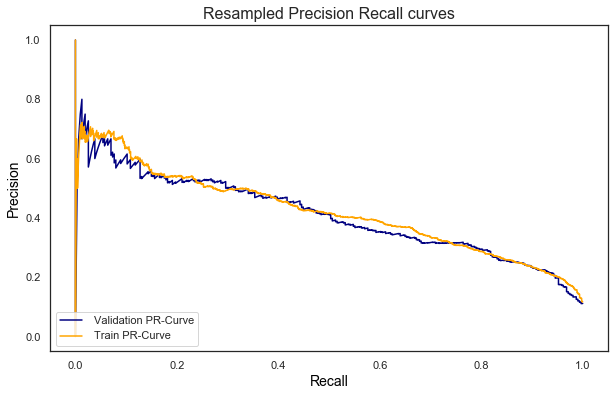

KNeighbors Classifier
Model report on training data:
Train: Precision: 0.7237
Train: Recall : 0.2821
Average Precision (Train): 0.5424
ROC AUC (Train): 0.6342
Train Accuracy: 0.9074

Model report on validation data:
Validation: Precision: 0.4196
Validation: Recall : 0.1497
Average Precision (Validation): 0.2703
ROC AUC (Validation): 0.5623
Validation Accuracy: 0.8854


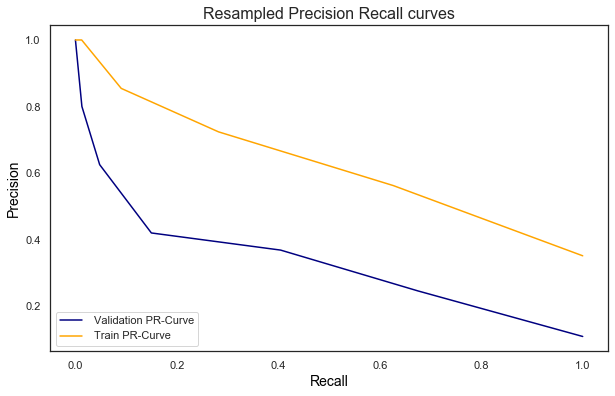

RandomForest Classifier
Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.5542
Validation: Recall : 0.1465
Average Precision (Validation): 0.4052
ROC AUC (Validation): 0.5661
Validation Accuracy: 0.8948


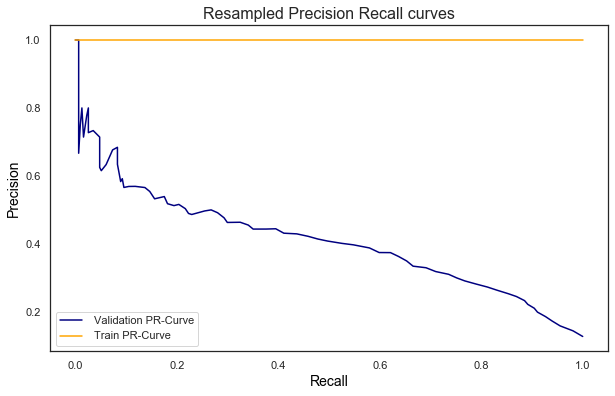

Support Vector Classifier
Model report on training data:
Train: Precision: 0.8814
Train: Recall : 0.1067
Average Precision (Train): 0.6490
ROC AUC (Train): 0.5524
Train Accuracy: 0.8982

Model report on validation data:
Validation: Precision: 0.5227
Validation: Recall : 0.0732
Average Precision (Validation): 0.3766
ROC AUC (Validation): 0.5326
Validation Accuracy: 0.8923


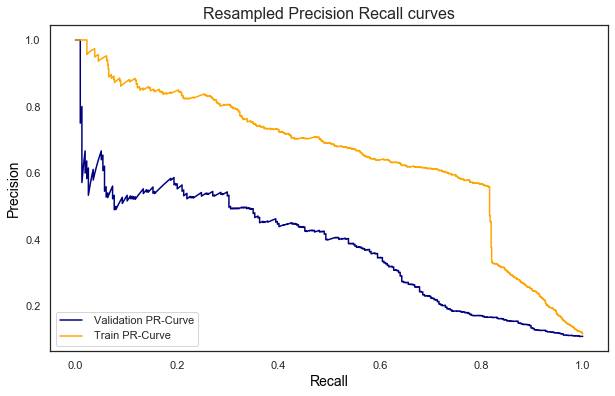

In [85]:
resamp_eval(ros, X_train, y_train)

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.803658,0.305344,0.636943,0.412797,0.730430,0.391533
1,KNeighborsClassifier,0.758799,0.257862,0.652866,0.369702,0.712269,0.367983
2,RandomForestClassifier,0.851622,0.350515,0.433121,0.387464,0.667799,0.353466
3,SVC,0.812629,0.299475,0.544586,0.386441,0.694894,0.338499


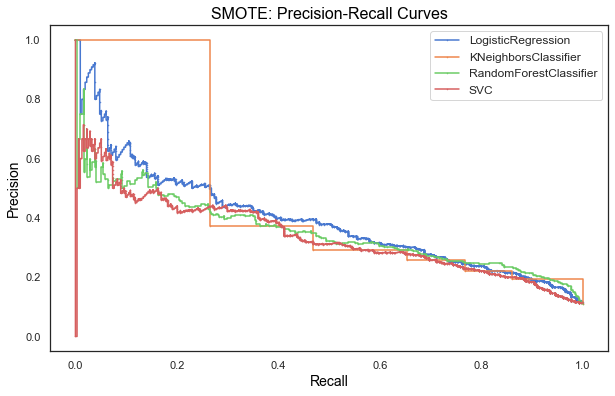

In [45]:
show_metrics(smote_X, smote_y, 'SMOTE: Precision-Recall Curves')

Unfortunately, SMOTE technique did not perform as well as the undersampling and oversampling techniques.

### SMOTEENN

In [38]:
#use SMOTEENN to fit the models and predict y
smoteenn_X, smoteenn_y = smoteenn.fit_sample(X_train, y_train)
smoteenn_X = pd.DataFrame(data=smoteenn_X, columns=columns )
smoteenn_y = pd.DataFrame(data=smoteenn_y, columns=['CVD_risk'])

Logistic Regression
Model report on training data:
Train: Precision: 0.9066
Train: Recall : 0.9107
Average Precision (Train): 0.9711
ROC AUC (Train): 0.8894
Train Accuracy: 0.8930

Model report on validation data:
Validation: Precision: 0.2525
Validation: Recall : 0.8057
Average Precision (Validation): 0.4009
ROC AUC (Validation): 0.7579
Validation Accuracy: 0.7205


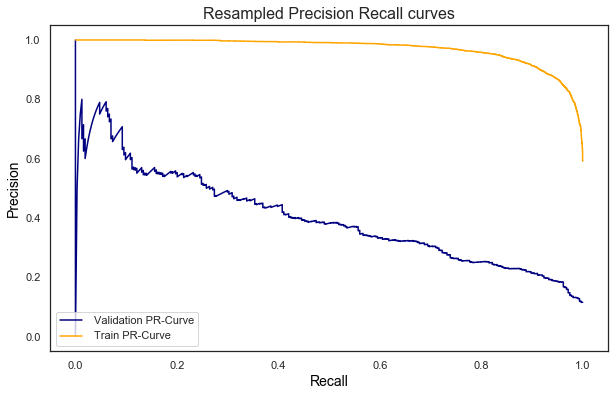

KNeighbors Classifier
Model report on training data:
Train: Precision: 0.9718
Train: Recall : 0.9993
Average Precision (Train): 0.9998
ROC AUC (Train): 0.9793
Train Accuracy: 0.9827

Model report on validation data:
Validation: Precision: 0.2256
Validation: Recall : 0.7643
Average Precision (Validation): 0.2621
ROC AUC (Validation): 0.7227
Validation Accuracy: 0.6901


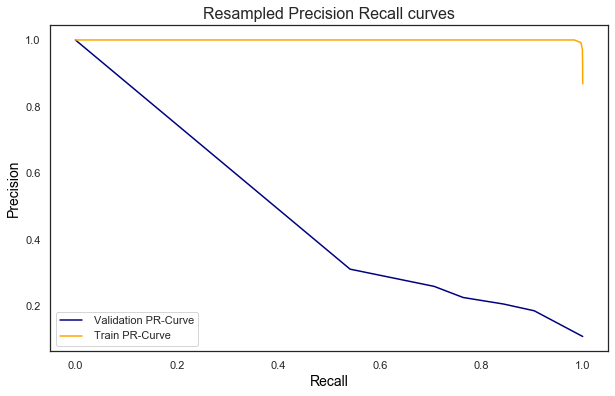

RandomForest Classifier
Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.2749
Validation: Recall : 0.7197
Average Precision (Validation): 0.3585
ROC AUC (Validation): 0.7445
Validation Accuracy: 0.7640


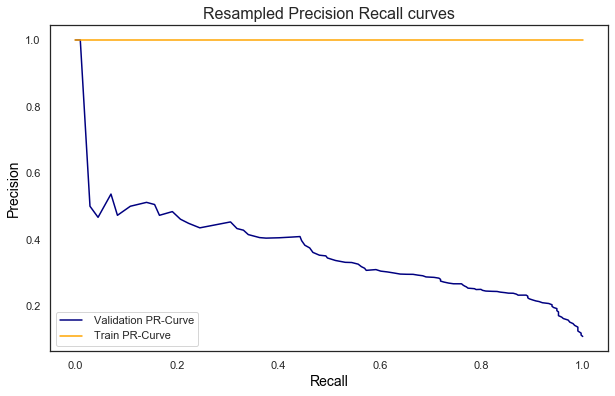

Support Vector Classifier
Model report on training data:
Train: Precision: 0.9478
Train: Recall : 0.9609
Average Precision (Train): 0.9886
ROC AUC (Train): 0.9433
Train Accuracy: 0.9462

Model report on validation data:
Validation: Precision: 0.2612
Validation: Recall : 0.7420
Average Precision (Validation): 0.3577
ROC AUC (Validation): 0.7435
Validation Accuracy: 0.7447


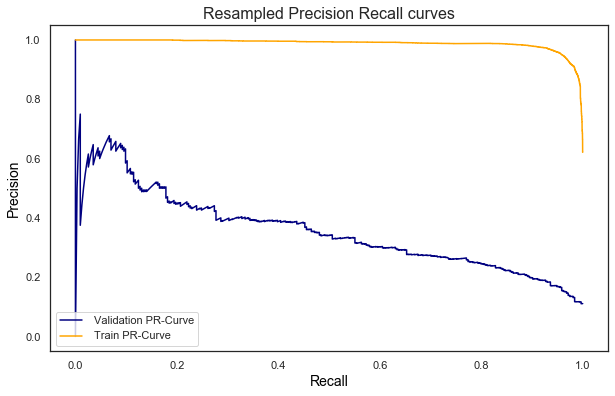

In [86]:
resamp_eval(smoteenn, smoteenn_X, smoteenn_y)

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.720497,0.252495,0.805732,0.384498,0.757936,0.398134
1,KNeighborsClassifier,0.690131,0.225564,0.764331,0.348331,0.722723,0.458969
2,RandomForestClassifier,0.760870,0.271961,0.719745,0.394760,0.742806,0.360847
3,SVC,0.744651,0.261211,0.742038,0.386401,0.743504,0.354799


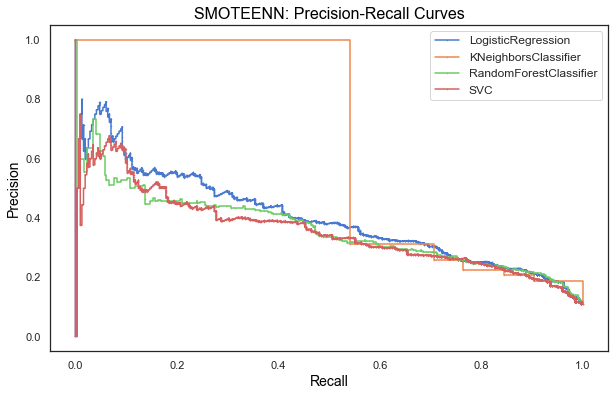

In [48]:
show_metrics(smoteenn_X, smoteenn_y, 'SMOTEENN: Precision-Recall Curves')

SMOTEENN worked better than SMOTE technique but the best recall scores.

Based on the recall score, both undersampling and oversampling show similar performance with Logistic Regression. SMOTEEN technique shoed the best performance with KNeighbors Classifier. Oversampling and undersampling showed the best results with Random Forest and SVC, respectively. We will now perform hyperparameter tuning on these models with the appropriate sampling techniques.

In [49]:
#define a function to plot precision recall curves for different models for different sampling sampling techniques
def resample_plots(X_sam, y_sam, label):
    pred_sam = model.fit(X_sam, y_sam).predict_proba(X_val)
    y_score_sam = pred_sam[:,1]
    model_precision_sam, model_recall_sam, _ = precision_recall_curve(y_val, y_score_sam)
    plt.step(model_recall_sam, model_precision_sam, marker='.', label=label)      
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()

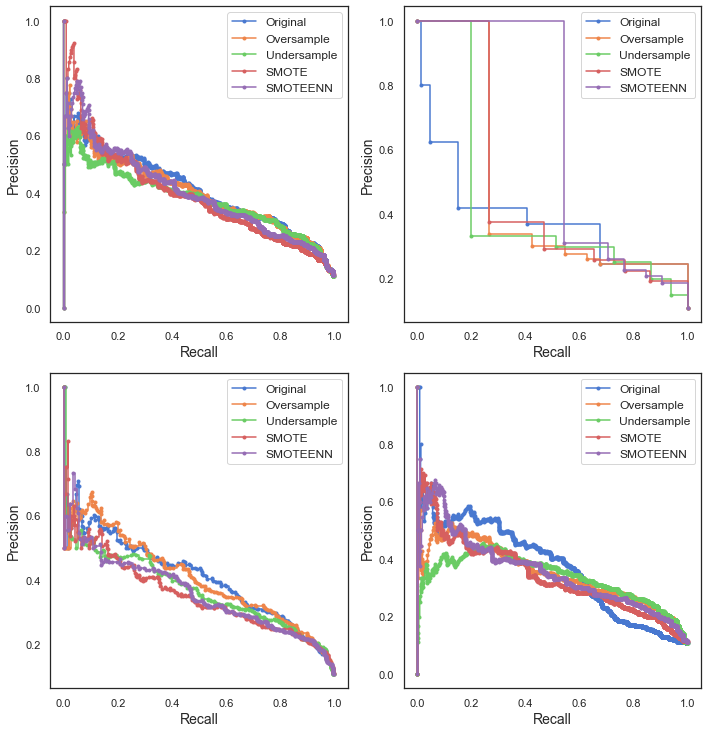

In [50]:
#precision recall curves using different sampling models using logistic regression, KNN, Random forest Classifier and 
#Support Vector Classifier
plt.subplots(figsize=(10,20))
MLA = (lr, knn, rf, svc)
for i, model in enumerate(MLA):
    plt.subplot(len(MLA),2,i+1)
    resample_plots(X_train, y_train, 'Original')
    resample_plots(os_X, os_y, 'Oversample')
    resample_plots(us_X, us_y, 'Undersample')
    resample_plots(smote_X, smote_y, 'SMOTE')
    resample_plots(smoteenn_X, smoteenn_y, 'SMOTEENN')

In [51]:
def show_resamp_metrics(model, title):
    methods = [ros, rus, smote, smoteenn]
    for method in methods:
        method_name = method.__class__.__name__
        resample_X, resample_y = method.fit_sample(X_train, y_train)
        resampled_X = pd.DataFrame(data=resample_X, columns=columns)
        resampled_y = pd.DataFrame(data=resample_y, columns=['CVD_risk'])
        
        pred = model.fit(resampled_X, resampled_y).predict(X_val)
        pred_prob = model.predict_proba(X_val)
        fp, tp, th = roc_curve(y_val, pred)     
        y_score = pred_prob[:,1]
        
        model_precision, model_recall, model_thresholds = precision_recall_curve(y_val, y_score)
        
        plt.step(model_recall, model_precision, marker='.', markersize=1, label=method_name)
        plt.xlabel('Recall', color='black', fontsize=14)
        plt.ylabel('Precision', color='black', fontsize=14)
        plt.title(title, fontsize=16, color='black')
        plt.legend(fontsize=12)

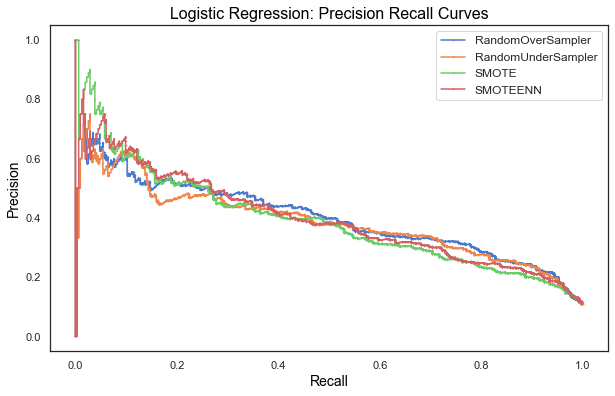

In [89]:
plt.figure(figsize=(10, 6))
show_resamp_metrics(lr, 'Logistic Regression: Precision Recall Curves')

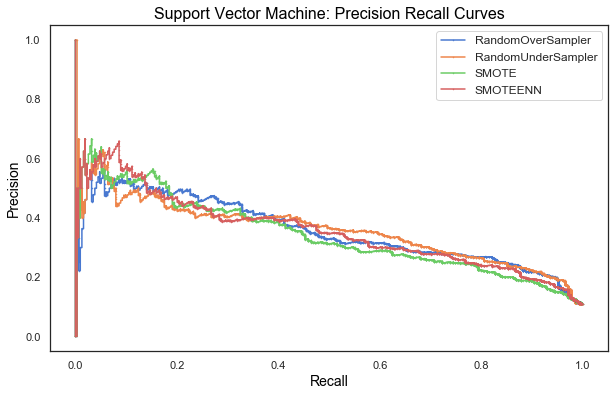

In [90]:
plt.figure(figsize=(10, 6))
show_resamp_metrics(svc, 'Support Vector Machine: Precision Recall Curves')

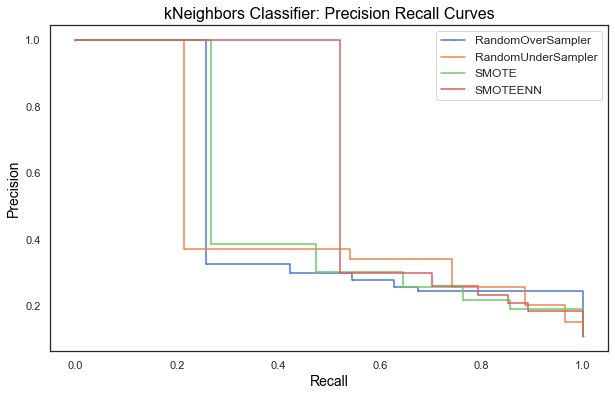

In [91]:
plt.figure(figsize=(10, 6))
show_resamp_metrics(knn, 'kNeighbors Classifier: Precision Recall Curves')

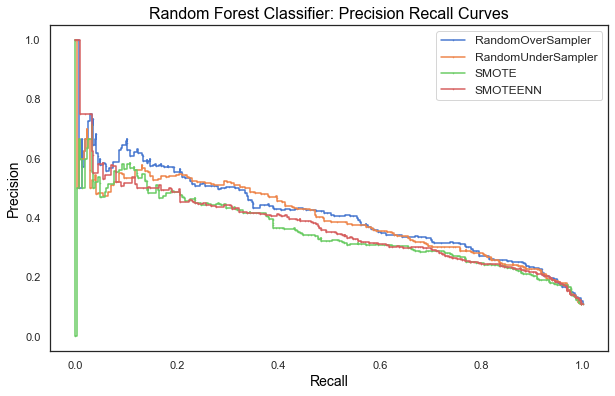

In [93]:
plt.figure(figsize=(10, 6))
show_resamp_metrics(rf, 'Random Forest Classifier: Precision Recall Curves')

## Hyperparameter Tuning

In [56]:
#create an empty dataframe to record our results
model_compare = pd.DataFrame(columns=['Model', 'Sampling', 'Precision', 'Recall', 'PRC_AUC', 'ROC_AUC'])
model_compare

,Model,Sampling,Precision,Recall,PRC_AUC,ROC_AUC


In [57]:
#make a pipeline that selects best features, performs oversampling and then Logistic Regression
steps = [('selectkbest', SelectKBest(f_classif)),('ros',RandomOverSampler(random_state=42)),
         ('LR', LogisticRegression(random_state=42))]

pipeline_ros = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'selectkbest__k': k, 'LR__C':[.001,.01,.1,1,10, 100], 'LR__solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'LR__penalty': ['l2']}]

lros_cv = GridSearchCV(pipeline_ros, params, cv=5, n_jobs=-1, scoring='recall')

lros_cv.fit(X_train, y_train)

y_pred = lros_cv.predict(X_val)

y_predprob = lros_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(lros_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_predprob)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'Logistic Regression',
                                      'Sampling': 'Oversampled',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.97      0.69      0.81      2584
           1       0.24      0.81      0.38       314

    accuracy                           0.71      2898
   macro avg       0.61      0.75      0.59      2898
weighted avg       0.89      0.71      0.76      2898

Tuned Model Parameters: {'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__solver': 'liblinear', 'selectkbest__k': 12}

Confusion Matrix: 
 [[1795  789]
 [  59  255]]

Precision: 0.2443
Recall: 0.8121

Area under PRC: 0.3599
Area under ROC: 0.8273


In [58]:
#make a pipeline that selects best features, performs undersampling and then Logistic Regression
steps = [('selectkbest', SelectKBest(f_classif)),('rus',RandomUnderSampler(random_state=42)),
         ('LR', LogisticRegression(random_state=42))]

pipeline_rus = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'selectkbest__k': k, 'LR__C':[0.001, .01,.1,1,10, 100], 'LR__solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'LR__penalty': ['l2']}]

lrus_cv = GridSearchCV(pipeline_rus, params, cv=5, scoring='recall')

lrus_cv.fit(X_train, y_train)

y_pred = lrus_cv.predict(X_val)

y_predprob = lrus_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(lrus_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_predprob)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'Logistic Regression',
                                      'Sampling': 'Undersampled',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      2584
           1       0.22      0.85      0.34       314

    accuracy                           0.65      2898
   macro avg       0.59      0.74      0.55      2898
weighted avg       0.89      0.65      0.71      2898

Tuned Model Parameters: {'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__solver': 'liblinear', 'selectkbest__k': 12}

Confusion Matrix: 
 [[1608  976]
 [  46  268]]

Precision: 0.2154
Recall: 0.8535

Area under PRC: 0.3346
Area under ROC: 0.8175


In [41]:
#make a pipeline that selects best features, performs oversampling and then Logistic Regression
steps = [('selectkbest', SelectKBest(f_classif)),('smoteenn',SMOTEENN(random_state=42)),
         ('LR', LogisticRegression(random_state=42))]

pipeline_smtn = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'selectkbest__k': k, 'LR__C':[.001,.01,.1,1,10, 100], 'LR__solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'LR__penalty': ['l2']}]

lrsmtn_cv = GridSearchCV(pipeline_smtn, params, cv=5, n_jobs=-1, scoring='recall')

lrsmtn_cv.fit(X_train, y_train)

y_pred = lrsmtn_cv.predict(X_val)

y_predprob = lrsmtn_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(lrsmtn_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_predprob)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'Logistic Regression',
                                      'Sampling': 'SMOTEENN',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.98      0.60      0.74      2584
           1       0.21      0.90      0.35       314

    accuracy                           0.63      2898
   macro avg       0.60      0.75      0.54      2898
weighted avg       0.90      0.63      0.70      2898

Tuned Model Parameters: {'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__solver': 'liblinear', 'selectkbest__k': 18}

Confusion Matrix: 
 [[1545 1039]
 [  30  284]]

Precision: 0.2147
Recall: 0.9045

Area under PRC: 0.3750
Area under ROC: 0.8366


NameError: name 'model_compare' is not defined

In [60]:
#make a pipeline that selects best features, performs undersampling and then Support Vector Classifier
steps = [('selectkbest', SelectKBest(f_classif)), ('rus', RandomUnderSampler(random_state=42)),
         ('SVC', SVC(random_state=42, probability=True))]

pipeline_svc_rus = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'selectkbest__k': k, 'SVC__C': [0.1, 0.01], 'SVC__gamma': [1, 0.1], 'SVC__kernel': ['linear', 'rbf']}]

svcus_cv = GridSearchCV(pipeline_svc_rus, params, cv=5, scoring='recall')

svcus_cv.fit(X_train, y_train)

y_pred = svcus_cv.predict(X_val)

y_predprob = svcus_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(svcus_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_predprob)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'Support Vector Classifier',
                                      'Sampling': 'Undersampled',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.98      0.32      0.48      2584
           1       0.15      0.96      0.25       314

    accuracy                           0.39      2898
   macro avg       0.57      0.64      0.37      2898
weighted avg       0.89      0.39      0.46      2898

Tuned Model Parameters: {'SVC__C': 0.01, 'SVC__gamma': 1, 'SVC__kernel': 'rbf', 'selectkbest__k': 14}

Confusion Matrix: 
 [[ 829 1755]
 [  13  301]]

Precision: 0.1464
Recall: 0.9586

Area under PRC: 0.5542
Area under ROC: 0.5000


In [62]:
#make a pipeline that selects best features, performs undersampling and then Logistic Regression
steps = [('selectkbest', SelectKBest(f_classif)), ('rus',RandomUnderSampler(random_state=42)),
         ('RF', RandomForestClassifier(random_state=42))]

pipeline_rf_rus = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'selectkbest__k': k, 'RF__n_estimators':[200, 400, 600]}]

rfus_cv = GridSearchCV(pipeline_rf_rus, params, cv=5, scoring='recall')

rfus_cv.fit(X_train, y_train)

y_pred = rfus_cv.predict(X_val)

y_predprob = rfus_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(rfus_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_predprob)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'Random Forest',
                                      'Sampling': 'Undersampled',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      2584
           1       0.27      0.81      0.41       314

    accuracy                           0.75      2898
   macro avg       0.62      0.78      0.62      2898
weighted avg       0.89      0.75      0.79      2898

Tuned Model Parameters: {'RF__n_estimators': 600, 'selectkbest__k': 17}

Confusion Matrix: 
 [[1911  673]
 [  59  255]]

Precision: 0.2748
Recall: 0.8121

Area under PRC: 0.4148
Area under ROC: 0.8474


In [63]:
#let's look at the results dataframe where we have sorted the values by recall
model_compare.sort_values(by='Recall', ascending=False)

,Model,Sampling,Precision,Recall,PRC_AUC,ROC_AUC
3,Support Vector Classifier,Undersampled,0.146401,0.958599,0.554175,0.500000
2,Logistic Regression,SMOTEENN,0.214664,0.904459,0.374980,0.836612
1,Logistic Regression,Undersampled,0.215434,0.853503,0.334606,0.817513
0,Logistic Regression,Oversampled,0.244253,0.812102,0.359920,0.827280
5,Random Forest,Undersampled,0.274784,0.812102,0.414759,0.847363
4,Random Forest,Undersampled,0.264293,0.780255,0.356659,0.836083


We got a high recall (0.80), reasonably high precision (0.28), which is maximum compared amongst the lot and the maximum ROC_AUC (0.84) for Logistic Regression sampled using oversampling, we will be using this as our final model. But, first we will use it to get the feature importance. 

## Feature importance

In [42]:
#get the important features for oversampled dataset predicted using Logistic Regression
coef_lr = lrsmtn_cv.best_estimator_.named_steps['LR'].coef_[0]
selected_lr = lrsmtn_cv.best_estimator_.named_steps.selectkbest.get_support()

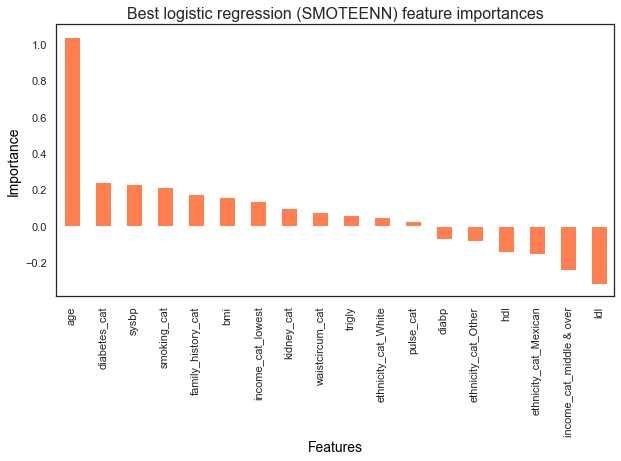

In [43]:
#plot the best estimated features
plt.subplots(figsize=(10, 5))
features = X_train.columns[selected_lr]
imps = pd.Series(coef_lr, index=features).sort_values(ascending=False)
imps.plot(kind='bar', color = 'coral')
plt.xlabel('Features', color='black', fontsize=14)
plt.ylabel('Importance', color='black', fontsize=14)
plt.title('Best logistic regression (SMOTEENN) feature importances', fontsize=16);

In [62]:
steps = [('selectkbest', SelectKBest(f_classif)),('smoteenn',SMOTEENN(random_state=42)),
         ('LR', LogisticRegression(random_state=42))]

pipeline_smtn = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'selectkbest__k': k, 'LR__C':[.001,.01,.1,1,10, 100], 'LR__solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'LR__penalty': ['l2']}]

lrsmtn_cv_final = GridSearchCV(pipeline_smtn, params, cv=5, n_jobs=-1, scoring='recall')

lrsmtn_cv_final.fit(X_train[['age', 'family_history_cat', 'diabetes_cat', 'smoking_cat', 'sysbp']], y_train)

y_pred = lrsmtn_cv_final.predict(X_val[['age', 'family_history_cat', 'diabetes_cat', 'smoking_cat', 'sysbp']])

y_predprob = lrsmtn_cv_final.predict_proba(X_val[['age', 'family_history_cat', 'diabetes_cat', 'smoking_cat', 'sysbp']])[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(lrsmtn_cv_final.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_predprob)
print('Area under ROC: %.4f'%(auc(fp, tp)))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      2584
           1       0.22      0.85      0.34       314

    accuracy                           0.65      2898
   macro avg       0.59      0.74      0.55      2898
weighted avg       0.89      0.65      0.72      2898

Tuned Model Parameters: {'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__solver': 'liblinear', 'selectkbest__k': 5}

Confusion Matrix: 
 [[1614  970]
 [  47  267]]

Precision: 0.2158
Recall: 0.8503

Area under PRC: 0.3014
Area under ROC: 0.8016


The predicted top features seem very reasonable with age, kidney function, family history, diabetes, waist circumference as the 5 most important fetaures.

In [63]:
datapath = '../data'
datapath_X_train = os.path.join(datapath, 'X_train.csv')
datapath_X_test = os.path.join(datapath, 'X_test.csv')
datapath_y_train = os.path.join(datapath, 'y_train.csv')
datapath_y_test = os.path.join(datapath, 'y_test.csv')
X_train.to_csv(datapath_X_train, index=False)
X_test.to_csv(datapath_X_test, index=False)
y_train.to_csv(datapath_y_train, index=False)
y_test.to_csv(datapath_y_test, index=False)

datapath_X = os.path.join(datapath, 'X.csv')
datapath_y = os.path.join(datapath, 'y.csv')
X.to_csv(datapath_X, index=False)
y.to_csv(datapath_y, index=False)

In [70]:
# Save the model
best_model = lrsmtn_cv_final.best_estimator_
best_model.version = 1.0
best_model.X_columns = [col for col in X_train.columns]
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
datapath_cvd_model = os.path.join(modelpath, 'CVD_prediction_model.pkl')
if not os.path.exists(datapath_cvd_model):
    with open(datapath_cvd_model, 'wb') as f:
        pickle.dump(best_model, f)

In [68]:
lrsmtn_cv_final.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=5)),
                ('smoteenn', SMOTEENN(random_state=42)),
                ('LR',
                 LogisticRegression(C=0.001, random_state=42,
                                    solver='liblinear'))])

In [69]:
y_test.shape

(2898,)